# Описание проекта
<a id="defenition"></a>



**Анализ рынка точек общественного питания с целью выбора лучшего варианта местоположения для открытия кафе с роботами-официантами**

<p><a href="https://yadi.sk/i/W_YGrE3_jk9D5w">ПРЕЗЕНТАЦИЯ ДОСТУПНА ПО ССЫЛКЕ</a> </p>

## Оглавление <a id='Оглавление'></a>


[Подключение библиотек, открытие исходных данных](#start)


[Изучение данных](#preprocessing)  
  * [Cоотношение видов объектов общественного питания по количеству](#step1)
  * [Cоотношение сетевых и несетевых заведений по количеству](#step2)
  * [Объекты питания имеющие сетевое распространение](#step3)
  * [Иссследование сетевых заведений](#step4)
  * [Исследование видов объектов общепита по числу мест](#step5)
  * [Выделение адреса точки питания](#step6)
  * [Топ-10 улиц по количеству объектов общественного питания](#step7)
  * [Расположение районов с малой плотностью точек общепита](#step8)
  * [Распределение количества посадочных мест заведений для районов с высокой плотностью точек питания](#step9)



[Заключение. Общий вывод](#resume)

*Опсание данных*
* __``id``__ — *идентификатор объекта;*
* __``object_name``__ — *название объекта общественного питания;*
* __``chain``__ — *сетевой ресторан;*
* __``object_type``__ — *тип объекта общественного питания;*
* __``address``__ — *адрес;*
* __``number``__ — *количество посадочных мест*

# Подключение библиотек, открытие исходных данных
<a id="start"></a>
[*Назад к оглавлению*](#Оглавление)

**Библиотеки**

In [1]:
import pandas as pd
import re

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

**Датасеты**

In [2]:
# открываем датасеты
try:
    rest = pd.read_csv('d:/home/datasets/rest_data.csv')
except:
    rest = pd.read_csv('/datasets/rest_data.csv')

**Настройки**

In [3]:
# настройки
pd.set_option('max_rows', 8)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams["figure.dpi"] = 75

**Изучение фрейма**

In [4]:
# типы данны, общий вид - случайная выборка из 5 строк
rest.info()
rest.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
10756,185860,TESTA,нет,ресторан,"город Москва, Лесная улица, дом 55, строение 1",45
10552,189032,Токмакоff,нет,кафе,"город Москва, Токмаков переулок, дом 12/20",40
12458,193192,Кулинария «Брецель»,нет,кафетерий,"город Москва, город Зеленоград, корпус 1130",7
272,69468,АРМЕНИЯ,нет,ресторан,"город Москва, Тверская улица, дом 17",144
11705,186525,Кафе «Кофе Порт»,нет,кафе,"город Москва, Пресненская набережная, дом 6, с...",7


In [5]:
rest.nunique()

id             15366
object_name    10393
chain              2
object_type        9
address         9108
number           315
dtype: int64

`chain`, `object_type` категорийные признаки, какие категории есть?

In [6]:
rest['object_type'].sort_values().unique().tolist()

['бар',
 'буфет',
 'закусочная',
 'кафе',
 'кафетерий',
 'магазин (отдел кулинарии)',
 'предприятие быстрого обслуживания',
 'ресторан',
 'столовая']

In [7]:
# пропуски
rest.isnull().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

In [8]:
# дубликаты
rest.duplicated().sum()

0

In [9]:
# одноименные заведения, сколько их
rest['object_name'].value_counts()

Столовая                                 267
Кафе                                     236
Шаурма                                   234
KFC                                      155
                                        ... 
Предприятие быстрого питания «ЭкоДом»      1
Кафе «Чемпион»                             1
Пельменчик                                 1
Нептун                                     1
Name: object_name, Length: 10393, dtype: int64

In [10]:
# одноименные заведения
rest.query('object_name== "Столовая"')[:2]

,id,object_name,chain,object_type,address,number
61,21214,Столовая,нет,столовая,"город Москва, Бабаевская улица, дом 3",90
438,154690,Столовая,нет,столовая,"город Москва, Коломенская улица, дом 5",5


In [11]:
# замена длинных названий
rest['object_type'].replace('предприятие быстрого обслуживания', 'фастфуд', inplace=True)
rest['object_type'].replace('магазин (отдел кулинарии)', 'магазин-кулинария', inplace=True)

*Пропусков, дубликатов нет по численным признакам. По `object_name` есть дубликаты названия заведения, но удалять дубликаты нельзя, потому что разные адреса заведений. В поле адрес, "улица"  стит либо после названия улицы, либо перед, также есть расширенный адрес как например "Москва, Киевское шоссе, 22 километр" . Требует приведение к одному виду. Число посадочных мест равное 0, можно считать нормальным, если точка питания работает на вынос**

## Cоотношение видов объектов общественного питания по количеству
<a id="step1"></a>
[*Назад к оглавлению*](#Оглавление)

In [12]:
# группировка по типу, агрегация, подсчет
rest_types = rest \
                .groupby('object_type', as_index=False) \
                .agg({'id':'count'}) \
                .sort_values(by='id', ascending=False)
rest_types.rename(columns={'id':'number'}, inplace=True)

**график**

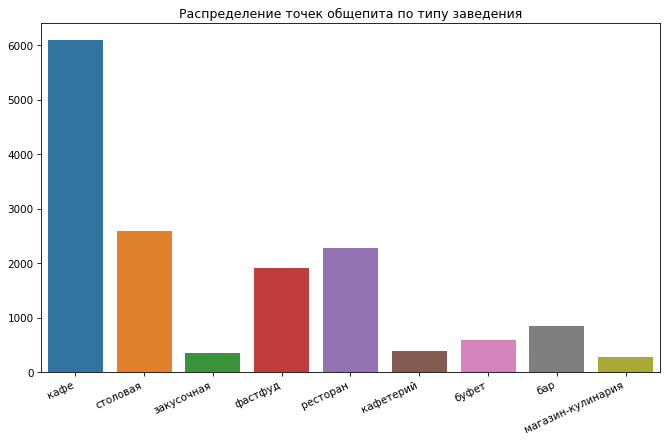

In [13]:
# для презентации убраты подписи осей

p = sns.countplot(data=rest, x = 'object_type')\
                .set(title='Распределение точек общепита по типу заведения'\
                     ,xlabel=''\
                     ,ylabel=''); 

plt.xticks(rotation=25, ha='right');
plt.tight_layout()
plt.savefig("Rest_type.png",format='png',dpi=150)

Видно, что среди точек питания  преобладает кафе, далее в одну группу по количеству точек можно выделить столовые, рестораны и фастфуд. На даном этапе преимущество кафе по количеству перед другими типами можно объяснить более низкими ценами , чем в ресторане, наличием комфорта по сравнению со столововымии и предприятиями фастфуда

## Cоотношение сетевых и несетевых заведений по количеству
<a id="step2"></a>
[*Назад к оглавлению*](#Оглавление)

**группировка по сетевому признаку**

In [14]:
rest_chain = rest \
        .groupby('chain', as_index=False)['id'] \
        .count().sort_values(by='id', ascending=False) 
rest_chain.rename(columns={'id':'count'}, inplace=True)
rest_chain['chain'].replace({'нет': 'не сетевая точка', 'да':'сетевая точка'}, inplace=True, regex=True)
rest_chain

,chain,count
1,не сетевая точка,12398
0,сетевая точка,2968


**строим график**

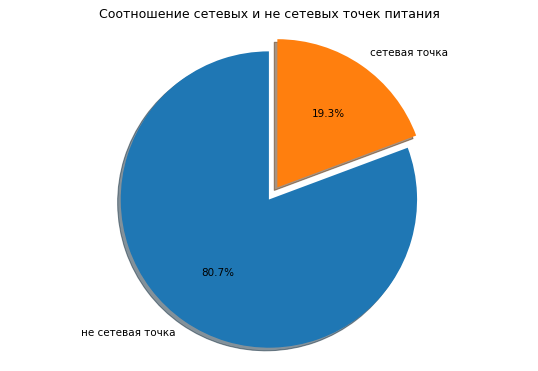

In [15]:
labels = rest_chain.chain;
explode = (0.1, 0);

fig, ax = plt.subplots();
ax.pie(rest_chain['count'], explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90);
ax.axis('equal'); 
ax.set_title("Соотношение сетевых и не сетевых точек питания")
plt.show();
fig.savefig("Rest_chain.png",format='png',dpi=150);


Сетевые точки общепита занимают 20% рынка. Абсолютное большинство за розничными точками питания

## Объекты питания имеющие сетевое распространение
<a id="step3"></a>
[*Назад к оглавлению*](#Оглавление)

In [16]:
# группировка по типу точки и типу сети, агрегация, подсчет
rest_types = rest \
                .groupby(['object_type' , 'chain'], as_index=False) \
                .agg({'id':'count'}) \
                .sort_values(by='object_type', ascending=False) \
                .reset_index()
rest_types.rename(columns={'id':'number'}, inplace=True)
del rest_types['index']
rest_types[:4]

,object_type,chain,number
0,фастфуд,нет,1132
1,фастфуд,да,791
2,столовая,нет,2584
3,столовая,да,3


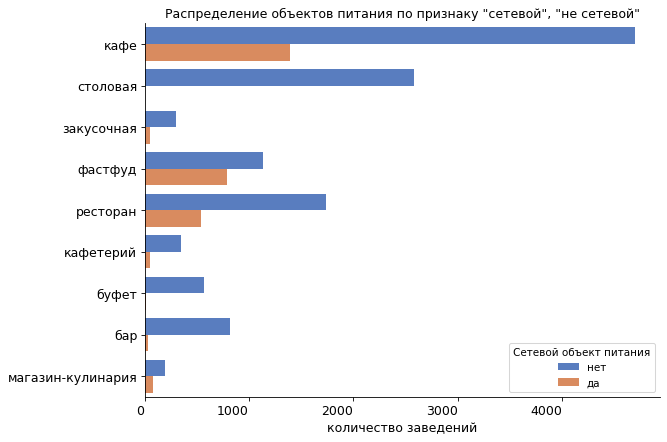

In [17]:
fig, ax = plt.subplots();
sns.countplot(data=rest, y="object_type", hue="chain", palette="muted", ax=ax)\
                .set(title='Распределение объектов питания по признаку "сетевой", "не сетевой"'\
                     ,ylabel='');

sns.despine(ax=ax, right=True);
ax.set_xlabel("количество заведений", fontsize=12);
l = ax.legend();
l.set_title('Сетевой объект питания');
#fig.show();

plt.xticks(rotation=0, ha='right', fontsize=12);
plt.yticks(rotation=0, ha='right', fontsize=12);
plt.tight_layout()
plt.savefig("Rest_chain_unchain.png",format='png',dpi=150);

In [18]:
# Соотношение сетевых и несетевых для каждого типа заведения
rest_ratio = []
for j in rest_types['object_type']:
    rest_ratio.append(rest_types[rest_types['object_type']==j]['number'].sum())
rest_types['size'] = rest_ratio
rest_types['ratio'] = rest_types['number']/rest_types['size']
rest_types[:4]

,object_type,chain,number,size,ratio
0,фастфуд,нет,1132,1923,0.59
1,фастфуд,да,791,1923,0.41
2,столовая,нет,2584,2587,1.00
3,столовая,да,3,2587,0.00


In [19]:
rest_types = rest_types[(rest_types['ratio'] > 0.05) & (rest_types['ratio'] < 0.95)]

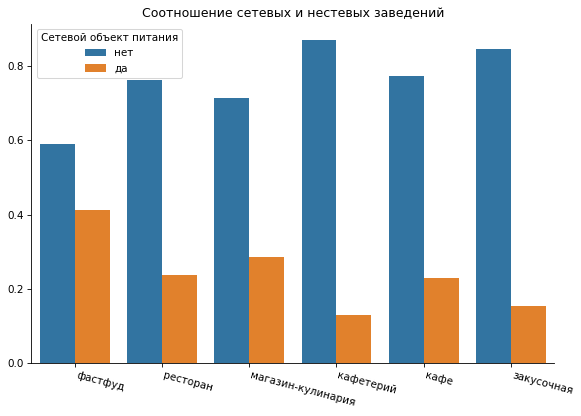

In [20]:
fig, ax = plt.subplots();
sns.barplot(x = 'object_type', y = 'ratio', data = rest_types, hue="chain")\
            .set(title='Соотношение сетевых и нестевых заведений'\
                 ,xlabel=''\
                 ,ylabel='');

sns.despine(ax=ax, right=True);
l = ax.legend();
l.set_title('Сетевой объект питания');
#fig.show();
plt.xticks(rotation=345, ha='left', fontsize=10); 
fig.savefig("Rest_rataio.png",format='png',dpi=300);

Среди сетевых точек питания лидирует кафе и фастфуд. Среди типов точек питания преобладают несетевые продавцы, однако фастфуд почти 50% на 50% делится на сетевые маркеты и розничные точки питания. Остальные типы в пропорции 1:5, бары и буфеты среди сетевых отсутствуют

## Иссследование сетевых заведений
<a id="step4"></a>
[*Назад к оглавлению*](#Оглавление)

**Распредедение по числу мест в среднем  в сетевых заведениях**

c:\users\av_zaslonyuk\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


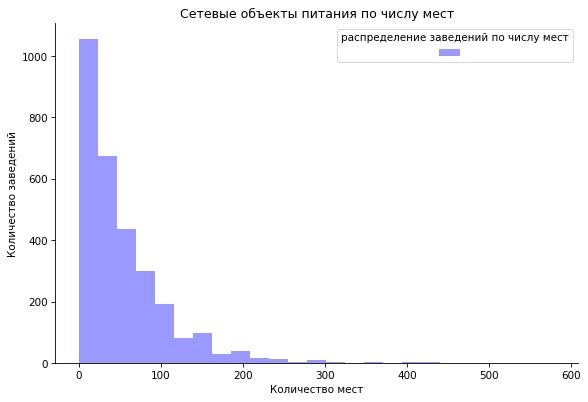

In [21]:
# предприятия сетевого питания
# грани убраны, для печати

#plt.style.use('dark_background')
fig, ax = plt.subplots();
sns.distplot(rest[rest['chain'] == "да"]['number']\
             , kde=False\
             , bins=25\
             , color='blue', ax=ax)\
        .set(title='Сетевые объекты питания по числу мест'\
                     ,xlabel='Количество мест'\
                     ,ylabel='Количество заведений');
l = ax.legend(' ');
sns.despine(ax=ax, right=True);
#sns.despine(ax=ax, left=True);
l.set_title('распределение заведений по числу мест');
plt.savefig("Rest_chain_place.png",format='png',dpi=150);

In [22]:
print(f"число улиц с количеством точек общепита равным 1: {rest[rest['chain'] == 'да'].shape[0]}")

число улиц с количеством точек общепита равным 1: 2968


Для сетевых заведений характерно большое число заведений с малым числом мест, более 50% от общего числа заведения с числом мест не превышающим 50

## Исследование видов объектов общепита по числу мест
<a id="step5"></a>
[*Назад к оглавлению*](#Оглавление)

In [23]:
placeses = rest\
        .groupby('object_type', as_index=False)\
        .agg({'number':'mean'})\
        .sort_values(by='number', ascending=False)



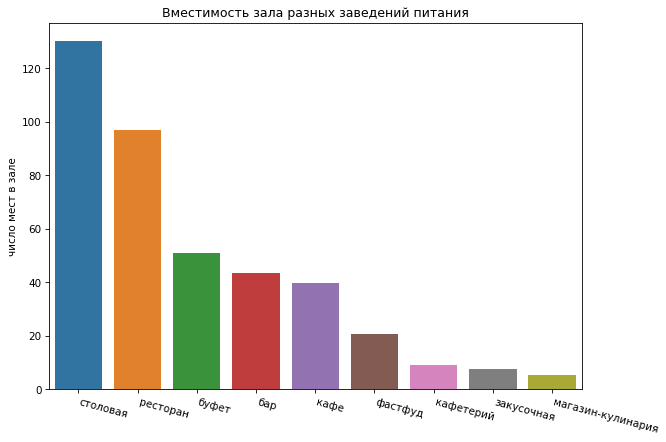

In [24]:
fig, ax = plt.subplots();
sns.barplot(x = 'object_type', y = 'number', data = placeses, ci = 0)\
            .set(title='Вместимость зала разных заведений питания'\
                 ,xlabel=''\
                 ,ylabel='число мест в зале');

plt.xticks(rotation=345, ha='left');
plt.tight_layout();
#plt.tight_layout();
plt.savefig("Rest_number_place.png",format='png',dpi=150);

Столовые и рестораны лидируют по числу посадочных мест в среднем по городу Москва. Что объяснимо, столовая имет высокую пропускную способность,а ресторан 

## Выделение адреса точки питания
<a id="step6"></a>
[*Назад к оглавлению*](#Оглавление)

Возможные сочетания с названием 

In [25]:
words = ['улица','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

rest["street"] = rest["address"].str.extract(str_pat, flags=re.IGNORECASE)
rest.sample(3)

,id,object_name,chain,object_type,address,number,street
8161,137704,Бургер герой пивной бар,нет,бар,"город Москва, улица Большая Ордынка, дом 19, с...",76,улица Большая Ордынка
13100,197385,Ребро Адама,нет,кафе,"город Москва, Мытная улица, дом 74",10,Мытная улица
5856,28874,школа 1986,нет,буфет,"город Москва, Новороссийская улица, дом 36",240,Новороссийская улица


## Топ-10 улиц по количеству объектов общественного питания
<a id="step7"></a>
[*Назад к оглавлению*](#Оглавление)

график топ-10 улиц по количеству объектов общественного питания

In [26]:
# Список ТОП-10 улиц
top10 = rest \
        .groupby('street',as_index=False)\
        .agg({'id':'count'}) \
        .sort_values(by='id', ascending=False)\
        .head(10).reset_index()

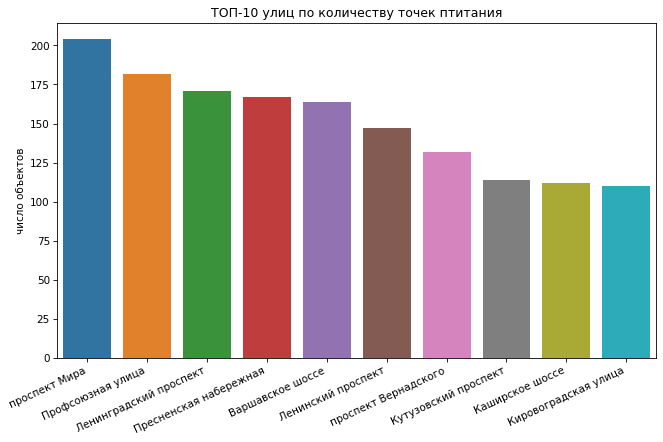

In [27]:
# ТОП-10 улиц по численности объектов
fig, ax = plt.subplots();

sns.barplot(data=top10, x = 'street', y = 'id', ci = 0)\
                .set(title='ТОП-10 улиц по количеству точек птитания'\
                     ,xlabel=''\
                     ,ylabel='число объектов');

plt.xticks(rotation=25, ha='right');
plt.tight_layout()
plt.savefig("Rest_street.png",format='png',dpi=300)

Максимальная плотность точек общепита достигается yна радиусах, улицах, которые соединияют ТТК и МКАД в основном Южный, Западный и Юго-Западный районый Москвы

## Расположение районов с малой плотностью точек общепита
<a id="step8"></a>
[*Назад к оглавлению*](#Оглавление)

In [28]:
# группировка по улице, агрегация, подсчет 
rest_1 = rest \
        .groupby('street', as_index=False)\
        .agg({'id':'count'}).sort_values(by='id', ascending=False)
rest_1 = rest_1[rest_1['id']==1]
print(f"число улиц с количеством точек общепита равным 1: {rest_1[rest_1['id'] == 1].shape[0]}")

число улиц с количеством точек общепита равным 1: 551


In [29]:
rest_1

,street,id
171,3-я Песчаная улица,1
139,2-я Филёвская улица,1
169,3-я Новоостанкинская улица,1
149,3-й Кадашёвский переулок,1
...,...,...
1486,улица Благуша,1
1487,улица Богданова,1
1488,улица Богородский Вал,1
952,Песчаный переулок,1


Улицы, на которых расположена одна точка общепита это небольшие улицы в основном в центре города

таблица улиц Москвы: https://docs.google.com/spreadsheets/d/1U1QGl6mDzV6DBFLDq4oH91SRprV93KFWJ3mcippMPug/edit?usp=sharing


коды районов: https://docs.google.com/spreadsheets/d/1MSvKjSfhO3LTKRcLUSEpfpFsHkGF_9o7rmnPbEmKRwQ/edit?usp=sharing



Объектами классификации в ОМК УМ являются линейные транспортные объекты, имеющие наименования и расположенные (полностью или частично) на территории города Москвы (далее – улицы Москвы), а именно: улицы, переулки, проезды, проектируемые (номерные) проезды, площади, набережные, шоссе, тупики, бульвары, аллеи, проспекты, просеки, линии, мосты, путепроводы, эстакады, тоннели, а также - километровые участки автодорог (в том числе, кольцевых) и трасс федерального значения.


- "Код ОМК ТЕ" (графа 6 перечня позиций раздела). Содержит код района / поселения из ОМК ТЕ, на территории которого расположен соответствующий объект классификации. В том случае, если объект классификации расположен на территории нескольких районов / поселений города Москвы, в данном поле содержатся все соответствующие коды по ОМК ТЕ, при этом между этими кодами устанавливается синтаксический разделитель - символ "точка с запятой";


In [30]:
from io import BytesIO
import requests
spreadsheet_id = "1U1QGl6mDzV6DBFLDq4oH91SRprV93KFWJ3mcippMPug"
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
streets = pd.read_csv(BytesIO(r.content))
streets[:2]

,UM_CODE,UM_NAMEF,global_id,UM_NAMES,UM_TRANS,UM_TYPE,UM_TM,UM_TE,UM_KLADR
0,008880,1-й Ирининский переулок,58481065,1-й Ирининский пер.,Pervy'j Irininskij pereulok,002,NaN,0102,77000000000706300
1,008890,2-й Ирининский переулок,58481066,2-й Ирининский пер.,Vtoroj Irininskij pereulok,002,NaN,0102,77000000000362200


In [31]:
# -dbg- 
# streets['UM_NAMES'].unique()
# streets[streets['UM_NAMES'].str.contains("ш", regex=False)]

In [32]:
# замена сокращений 
# ул <-> улиц
# ш.<-> шоссе
streets['UM_NAMES']=streets['UM_NAMES'].str.replace('ул.', 'улица')
streets['UM_NAMES']=streets['UM_NAMES'].str.replace('просп.', 'проспект')
streets['UM_NAMES']=streets['UM_NAMES'].str.replace('ш.', 'шоссе')
streets.sample(5)

c:\users\av_zaslonyuk\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
c:\users\av_zaslonyuk\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
c:\users\av_zaslonyuk\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,UM_CODE,UM_NAMEF,global_id,UM_NAMES,UM_TRANS,UM_TYPE,UM_TM,UM_TE,UM_KLADR
3718,048155,Уренгойская улица,58484840,Уренгойская улица,Urengojskaya ulicza,001,734910,1104,77007000005002000
3658,047855,Ключевая улица,58484780,Ключевая улица,Klyuchevaya ulicza,001,735960,1207,77014000030000300
96,009815,Каширский проезд,58481165,Кашоссерский пр.,Kashirskij proezd,003,NaN,0612;0613,77000000000049500
2677,042920,Солнечная улица,58483794,Солнечная улица,Solnechnaya ulicza,001,734640,1202,77005000003002500
2382,031570,проезд Шломина,58483486,пр. Шломина,proezd Shlomina,003,NaN,0101,77000000000707300


In [33]:
# ТОП 10 улиц (с указанием районов) на которых больше всего заведений
top10_streets_list = top10['street'].tolist()
top10_street = streets.query('UM_NAMES in @top10_streets_list')
top10_street

,UM_CODE,UM_NAMEF,global_id,UM_NAMES,UM_TRANS,UM_TYPE,UM_TM,UM_TE,UM_KLADR
113,010040,Кировоградская улица,58481183,Кировоградская улица,Kirovogradskaya ulicza,001,NaN,0619;0620;0621,77000000000146800
408,012970,Кутузовский проспект,58481479,Кутузовский проспект,Kutuzovskij prospekt,010,NaN,0805;0819,77000000000720000
443,013320,Ленинградский проспект,58481514,Ленинградский проспект,Leningradskij prospekt,010,NaN,0201;0202;0214;0217,77000000000168500
449,013380,Ленинский проспект,58481520,Ленинский проспект,Leninskij prospekt,010,NaN,0110;0610;0702;0706;0707;0709;0814;0817,77000000000168900
689,015820,проспект Мира,58481760,проспект Мира,prospekt Mira,010,NaN,0105;0301;0309;0310;0312;0313;0317,77000000000185600
1389,022180,Профсоюзная улица,58482469,Профсоюзная улица,Profsoyuznaya ulicza,001,NaN,0701;0704;0707;0709;0710;0712,77000000000239200
4368,003180,проспект Вернадского,58485499,проспект Вернадского,prospekt Vernadskogo,010,NaN,0702;0706;0814;0815;0817,77000000000095300


Список улиц на которых по 1 заведению

In [34]:
# ТОП  улиц (с кодом района) на которых 1 заведение
loss_streets_list = rest_1['street'].tolist()
loss_street = streets.query('UM_NAMES in @loss_streets_list')  
loss_street[:8]

,UM_CODE,UM_NAMEF,global_id,UM_NAMES,UM_TRANS,UM_TYPE,UM_TM,UM_TE,UM_KLADR
13,009000,4-я Кабельная улица,58481078,4-я Кабельная улица,Chetvyortaya Kabel`naya ulicza,001,NaN,0507,77000000000024600
37,009210,Калибровская улица,58481103,Калибровская улица,Kalibrovskaya ulicza,001,NaN,0310,77000000000141700
60,009460,улица Капотня,58481127,улица Капотня,ulicza Kapotnya,001,NaN,0505,77000000000733300
66,009530,1-я Карачаровская улица,58481134,1-я Карачаровская улица,Pervaya Karacharovskaya ulicza,001,NaN,0510,77000000000002200
87,009725,Каскадная улица,58481155,Каскадная улица,Kaskadnaya ulicza,001,NaN,0409,77000000000039800
99,009880,2-я Квесисская улица,58481169,2-я Квесисская улица,Vtoraya Kvesisskaya ulicza,001,NaN,0213,77000000000145700
118,010090,Кирпичная улица,58481188,Кирпичная улица,Kirpichnaya ulicza,001,NaN,0417,77000000000147100
131,010240,улица Клочкова,58481201,улица Клочкова,ulicza Klochkova,001,NaN,0819,77000000000148400


- Топ 10 районов где на улице  находится 1 заведение питания
- указаны количество таких улиц в районе

loss_street \
        .groupby('UM_TE',as_index=False)\
        .agg({'global_id':'count'}) \
        .sort_values(by='global_id', ascending=True)\
        .head(10)

In [35]:
# Список ТОП-10 районов, на которых улицы с 1 заведением
loss_street_region_list = loss_street \
        .groupby('UM_TE',as_index=False)\
        .agg({'global_id':'count'}) \
        .sort_values(by='global_id', ascending=False)\
        .head(10)\
        .reset_index()['UM_TE'].tolist()
loss_street_region_list = list(map(int, loss_street_region_list))
loss_street_region_list

[1207, 1105, 1209, 1111, 711, 813, 1204, 809, 1206, 307]

In [36]:
#losss_street_gr.global_id.sum()
#loss_street.UM_TE.count()

**Выделим название районов**



In [37]:
from io import BytesIO
import requests
spreadsheet_id = "1MSvKjSfhO3LTKRcLUSEpfpFsHkGF_9o7rmnPbEmKRwQ"
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
region = pd.read_csv(BytesIO(r.content))
region.sort_values(by='Kod', ascending=True, inplace=True)
region

,Kod,Name,global_id,Latin_name,Type,Kod_okato
0,100,Центральный административный округ,58703558,Czentral`ny'j administrativny'j okrug,2,45286000
1,101,район Арбат,58703559,rajon Arbat,3,45286552
2,102,Басманный район,58703560,Basmanny'j rajon,3,45286555
3,103,район Замоскворечье,58703561,rajon Zamoskvorech`e,3,45286560
...,...,...,...,...,...,...
154,1207,поселение Первомайское,58703713,poselenie Pervomajskoe,4,45298572
155,1208,поселение Роговское,58703714,poselenie Rogovskoe,4,45298575
156,1209,поселение Троицк,58703715,poselenie Troiczk,4,45298578
157,1210,поселение Щаповское,58703716,poselenie Shhapovskoe,4,45298583


In [38]:
region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 157
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Kod         158 non-null    int64 
 1   Name        158 non-null    object
 2   global_id   158 non-null    int64 
 3   Latin_name  158 non-null    object
 4   Type        158 non-null    int64 
 5   Kod_okato   158 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 8.6+ KB


В таблице улиц и районов типы данных для номера района разные

In [39]:
#losss_street_gr = losss_street_gr.astype({'UM_TE': object}, errors = 'ignore')
#
region = region.astype({'Kod': object})
loss_street_region = region.query('Kod in @loss_street_region_list')
loss_street_region[:5]

,Kod,Name,global_id,Latin_name,Type,Kod_okato
35,307,Лосиноостровский район,58703593,Losinoostrovskij rajon,3,45280565
104,711,район Южное Бутово,58703663,rajon Yuzhnoe Butovo,3,45293594
110,809,Можайский район,58703669,Mozhajskij rajon,3,45268569
112,813,район Внуково,58703671,rajon Vnukovo,3,45268552
140,1105,поселение Марушкинское,58703699,poselenie Marushkinskoe,4,45297562


Из всех районов, интересные Можайский, Внуково, Южное Бутово, Лосиноостровский. Районы расположены далеко от центра, возможен маленький поток клиентов, плотность заведения на улицу в этих районах самая маленькая возможно по этой причине. 

## Распределение количества посадочных мест заведений для районов с высокой плотностью точек питания
<a id="step9"></a>
[*Назад к оглавлению*](#Оглавление)

In [40]:
# сисок ТОП-10 улиц по числу точек питания
top_street = rest \
        .groupby('street', as_index=False)\
        .agg({'id':'count'}) \
        .sort_values(by='id', ascending=False)\
        .head(10).street.to_list()

# срез по ТОП-10 улиц 
rest_top = rest\
    .query('street in @top_street')\
    .groupby('object_type', as_index=False)\
    .agg({'number':'mean'})\
    .sort_values(by='number', ascending=False)

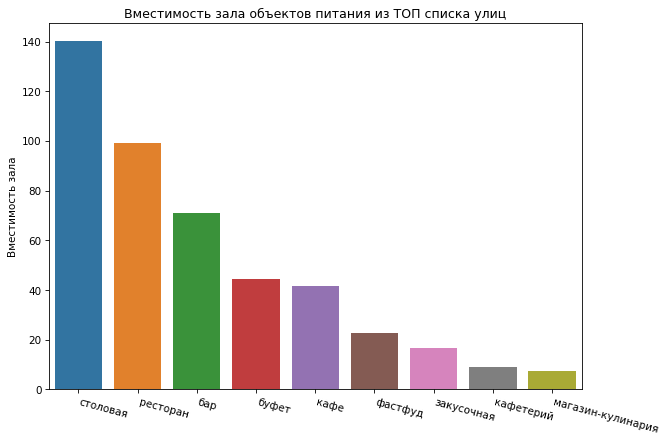

In [41]:
# График
sns.barplot(x = 'object_type', y = 'number', data = rest_top, ci = 0)\
        .set(title='Вместимость зала объектов питания из ТОП списка улиц'\
             ,xlabel=''\
             ,ylabel='Вместимость зала');

plt.xticks(rotation=345, ha='left');
plt.tight_layout();
plt.savefig("Rest_number_place_top10.png",format='png',dpi=150);

Среднее число посадочных мест в зале для заведений из списка ТОП улиц существенно отличается в большую сторону, чем от общего среднего распределения. Между тем по типу точки питания произошли изменения, рейтинг возглавляет столовые, ресторвны и бары подняди на 2 т 3 строку сотвественно. Это можно объяснить тем, что местоположение точек совпадает с центрами деловой активности

**Сколько заведений на топовых улицах по отношению ко всем?**

In [42]:
# ТОП
print(f"число объектов на ТОП-10 улицах: {rest.query('street in @top_street').object_name.count()}")
# одинокие объекты на маденьких улицах
print(f"число одиночных объектов: {rest_1.street.count()}")
# Все объекты
print(f"число объектов: {rest.object_name.count()}")

число объектов на ТОП-10 улицах: 1503
число одиночных объектов: 551
число объектов: 15366


# Вывод
<a id="resume"></a>
[*Назад к оглавлению*](#Оглавление)

* Стоит порекомендовать формат заведения кафе
* Среди сетевых точек питания преобладают небольшие заведения с числом мест около 50
* Первое заведение стоит открывать не в центре. 
* В центре отсутствет свободный подъезд, поток клиентов не постоянный, но вероятно аренда будет более высокой, а клпиент не поддержит концепт-кафе с роботами
* В центре поток клиентов отличается сезонностью, возможно следующий объект открыть в центре для туристов в формате кафетерия


<p><a href="https://yadi.sk/i/W_YGrE3_jk9D5w">Ссылка на презентацию</a> </p>